## Assignment 3 (Due 11 November 2016 by 11:59pm)

By Caroline Sofiatti Nunes

---
## Part a (5 points)
Implement an object-oriented PRNG based on the SHA-256 hash of a seed concatenated with a sequence number, in Python, by subclassing the class Random and overwriting the methods random(), seed(), getstate(), setstate(), jumpahead(), and getrandbits(). Your implementation should inherit shuffle(), choice(), sample(), randbelow(), etc., from the parent Random class.

In [1]:
import random
import hashlib as _hashlib
from os import urandom as _urandom
from binascii import hexlify as _hexlify

# Based on Wichmann-Hill
class FancyRandom(random.Random):
    """
    PRNG based on the SHA-256 hash of a seed concatenated with a sequence number
    You should overwrite the methods random(), seed(), getstate(), setstate(), jumpahead(), and getrandbits()
    """
    VERSION = 1     # used by getstate/setstate

    def seed(self, a=None):
        if a is None:
            try:
                a = int(_hexlify(_urandom(16)), 16)
            except NotImplementedError:
                import time
                a = int(time.time() * 256) # use fractional seconds

        if not isinstance(a, (int, int)):
            a = hash(a)

        a, x = divmod(a, 30268)
        a, y = divmod(a, 30306)
        a, z = divmod(a, 30322)
        self._seed = int(x)+1, int(y)+1, int(z)+1

        self.gauss_next = None

    def random(self):
        """Get the next random number in the range [0.0, 1.0)."""
        x, y, z = self._seed
        x = (171 * x) % 30269
        y = (172 * y) % 30307
        z = (170 * z) % 30323
        self._seed = x, y, z
        return (x/30269.0 + y/30307.0 + z/30323.0) % 1.0

    def getstate(self):
        """Return internal state; can be passed to setstate() later."""
        return self.VERSION, self._seed, self.gauss_next

    def setstate(self, state):
        """Restore internal state from object returned by getstate()."""
        version = state[0]
        if version == 1:
            version, self._seed, self.gauss_next = state
        else:
            raise ValueError("state with version %s passed to "
                             "Random.setstate() of version %s" %
                             (version, self.VERSION))

    def jumpahead(self, n):
        if not n >= 0:
            raise ValueError("n must be >= 0")
        x, y, z = self._seed
        x = int(x * pow(171, n, 30269)) % 30269
        y = int(y * pow(172, n, 30307)) % 30307
        z = int(z * pow(170, n, 30323)) % 30323
        self._seed = x, y, z

    def getrandombits(self, k):
        """getrandbits(k) -> x.  Generates an int with k random bits."""
        if k <= 0:
            raise ValueError('number of bits must be greater than zero')
        if k != int(k):
            raise TypeError('number of bits should be an integer')
        bytes = (k + 7) // 8                    # bits / 8 and rounded up
        x = int(_hexlify(_urandom(bytes)), 16)
        return x >> (bytes * 8 - k)             # trim excess bits


In [2]:
def test_random01(seed):
    """
    Test the random number is in the range [0.0, 1.0)
    """
    random_generator = FancyRandom()
    random_generator.seed(seed)
    res = random_generator.random()
    return res < 1 and res >= 0 

assert test_random01(123456)

def test_random01_all(n):
    """
    Test the random number is in the range [0.0, 1.0)
    for n different seeds
    """
    for i in range(n):
        if not test_random01(i):
            return False
    return True

assert test_random01_all(1000)

---
## Part b (8 points)
Implement tests of: 

(at least one for each, more tests will be **bonus**)
1. setting the seed: at least one test to take care of int, long, str seed
2. setting the state
3. getting the state
4. jumping ahead: at least one test for transitivity, "jump(a+b) = jump(a) followed by jump(b)"
5. getrandbits: at least one test to check exactly k bits are given
6. at least two tests for uniformity, with “reasonable” power to detect a bug, including a test using the Kolmogorov-Smirnov statistic for random() and a binomial test for the single-bit frequency for getrandbits().
7. tests that your class inherited the expected methods from the parent class

B.1. setting the seed: at least one test to check same seed gives same result

In [3]:
def test_seed():
    """
    at least check same seed will give same result
    """
    random_generator = FancyRandom()
    random_generator.seed(4)
    a = random_generator.random()
    random_generator.seed(4)
    b = random_generator.random()
    print(a, b)
    assert a == b
    
test_seed()

0.039528283053864105 0.039528283053864105


B.2. setting the state

In [4]:
def test_setstate():
    _inst = FancyRandom()
    state = _inst.getstate()
    next = _inst.random()
    _inst.setstate(state)
    nnext = _inst.random()
    print(next, nnext)
    if next == nnext:
        return True
    else:
        return False
    assert test_setstate()

test_setstate()

0.16176923168104151 0.16176923168104151


True

B.3. getting the state

In [5]:
# test_setstate works to test getstate as well. Here is another test:
def test_getstate():
    _inst = FancyRandom()
    state = _inst.getstate()
    _inst2 = FancyRandom()
    state2 = _inst.getstate()
    if state == state2:
        return True
    else:
        return False
assert test_getstate()

B.4. jumping ahead: at least one test for transitivity, "jump(a+b) = jump(a) followed by jump(b)"

In [6]:
def test_jumpingahead(a, b):
    _inst = FancyRandom(5)
    _inst2 = FancyRandom(5)
    _inst.jumpahead(a+b)
    _inst2.jumpahead(a)
    _inst2.jumpahead(b)
    print (_inst.random())
    print (_inst2.random())
    if _inst.random() == _inst2.random():
        return True
    else:
        return False
test_jumpingahead(10,20)
assert test_getstate()    

0.2597236074008813
0.2597236074008813


B.5. getrandbits: at least one test to check exactly k bits are given

In [7]:
import math
def number_of_bits(n):
    return int(math.log(n, 2)) + 1

def test_getrandombits(k):
    """
    Test exactly k bits are given
    """
    random_generator = FancyRandom(5)
    num = random_generator.getrandombits(k)
    num_to_bits = num.bit_length()
    print(k, num_to_bits)
    if k == num_to_bits:
        return True
    else:
        return False
    
test_getrandombits(1)
test_getrandombits(32)

1 1
32 31


False

B.6.1. Kolmogorov-Smirnov statistic for random()

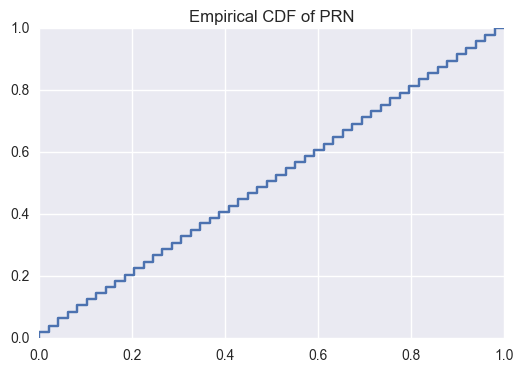

KstestResult(statistic=0.50003529221910892, pvalue=4.3751668954428169e-12) 0.0136


In [8]:
import numpy as np
import scipy.stats as stats
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def test_uniform_KS():
    """
    Kolmogorov-Smirnov statistic for random()
    make sure the KS test statistics is small enough
    """
    N = 10000
    data = [FancyRandom().random() for x in range(N)]
    ecdf = ECDF(data)
    
    x = np.linspace(min(data), max(data))
    y = ecdf(x)
    plt.title("Empirical CDF of PRN")
    plt.step(x, y)
    plt.show()
    D_KS = stats.kstest(x, 'norm')
    
    #Kolmogorov-Smirnov test statistics, 95% confidence interval
    print(D_KS, 1.36/np.sqrt(N))
    assert D_KS[1] < 1.36/np.sqrt(N)
    
    
test_uniform_KS()

B.6.2. binomial test for the single-bit frequency for getrandbits().

In [40]:
import scipy.stats

def test_uniform_binomial():
    """
    binomial test for the single-bit frequency for getrandombits().
    make sure the p-value is large enough. 
    """
    N = 100000
    k = 10
    success = 0
    for i in range(N):
        random_generator = FancyRandom(5)
        num = random_generator.getrandombits(k)
        num_to_bits = num.bit_length()
        if num_to_bits==10:
            success += 1
    print(success, N)
    p_value = scipy.stats.binom_test(success, N)
    print(p_value)
    assert p_value > 0.8
    
test_uniform_binomial()
#test_uniform_binomial()

50040 100000
0.802726753309


B.7. tests that your class inherited the expected methods from the parent class

According to the assignment: "Your implementation should inherit `shuffle()`, `choice()`, `sample()`, `randbelow()`...from parent class"

NOTE: I can't find the documentation for `randbelow()`. Perhaps it's been depricated? It isn't importated, but I can't find evidence that this method belongs to `random.Random`

In [ ]:
 def test_inherited():
    _inst = FancyRandom()
    x = np.arange(10)
    shuffled = _inst.shuffle(x)
    chosen = _inst.choice([1,2,3,4])
    sample = _inst.sample([1,2,3,4], 2)
    print(x, chosen, sample)
    return

test_inherited()

All methods work. I'm not sure how to formally test inheritance. I read that unit testing wasn't the way to go.

---
## Part c (2 points)
Use the Jupyter “magic” %timeit command to compare the amount of time it takes to generate $10^5$ PRNs using your SHA-256 method and using the default Python PRNG. Use the first cell to time your method, the second cell to time Python method, the third cell to discuss possible reasons for the difference. 

In [ ]:
import uuid

### Generating $10^5$  pseudo-random numbers using SHA-256

In [ ]:
#? %timeit

In [ ]:
def prn_sha256():
    for i in range(100000):
        data = uuid.uuid4().hex
        prn = int(_hashlib.sha256(data.encode()).hexdigest(), 16)

print('SHA-256: ')
%timeit -n10000 -r100 prn_sha256

### Generating $10^5$  pseudo-random numbers using Default Python PRNG

In [ ]:
def prn_default():
    for i in range(100000):
        prn = random.randint(0, 10e70)
        
print('Python Default: ')
%timeit -n10000 -r100 prn_default

## Conclusion: Both have very similar performance